**ドライブ共有準備**

In [1]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./gdrive




---



# KerasでCNNを使って画像分類器(くるみ/モカ/その他ワンこ判定)を作る例
*   Kerasはtensorflowなどで動くPythonで書かれたニューラルネットワークライブラリ。詳細は[こちら](https://keras.io/ja/)。
*   自前の分類器作成で参考にした記事は[ここ](https://newtechnologylifestyle.net/keras%E3%81%AEcnn%E3%82%92%E4%BD%BF%E7%94%A8%E3%81%97%E3%81%A6%E3%82%AA%E3%83%AA%E3%82%B8%E3%83%8A%E3%83%AB%E7%94%BB%E5%83%8F%E3%81%A7%E7%94%BB%E5%83%8F%E8%AA%8D%E8%AD%98%E3%82%92%E8%A1%8C%E3%81%A3/)。

**データアップロード（Google DriveからColabへのファイルアップロード）**

In [0]:
!!pip install -U -q PyDrive

In [0]:
# Google Driveアクセス準備
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Google Driveからのコピー
id = '1icpF-Z7x202u_6AOxjRsDmTk_gy7oZNw'  # 共有リンクで取得した id= より後の部分(mocha.zipの例)
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('mocha.zip')
id = '1-uXHH1VAZim-YuCrWl-aO9B2AM6LrTB5'  # 共有リンクで取得した id= より後の部分(kuru.zipの例)
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('kuru.zip')
id = '1L2WozAd2ABZU39p8fKVStGbyqZTgrxnA'  # 共有リンクで取得した id= より後の部分(otrdog.zipの例)
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('otrdog.zip')
# 終わったら、ファイル画面の更新をして確認

In [0]:
# Zipの場合は展開
!unzip mocha.zip
!unzip kuru.zip
!unzip otrdog.zip

### データ準備

In [0]:
# ライブラリインポート
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import glob

In [0]:
folder = ["kuru","mocha","otrdog"]
image_size = 32

X = []
Y = []
for index, name in enumerate(folder):
    dir = "/content/" + name
    files = glob.glob(dir + "/*.jpg")
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)

X = np.array(X)
Y = np.array(Y)

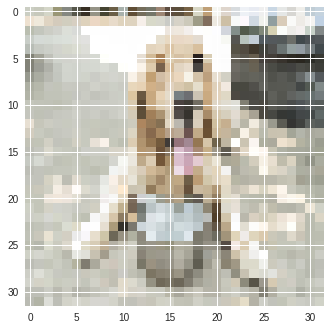

In [9]:
# 画像データ(画像)の確認
import matplotlib.pyplot as plt
plt.imshow(X[90])  # 画像表示
plt.show()

In [0]:
# 画像データ(配列)の確認
# （データは32×32で、それぞれにRGB値(0-255)が格納されている）
print(X[6])

In [0]:
# RGB値を正規化（0～255のRGB値を255で割り算して、0～1の値に正規化する）
X = X.astype('float32')
X = X / 255.0
#print(X[5])      # 一応、確認

機械学習に適用させるため、ラベルデータをone-hotベクトルに変換（しないとダメらしい） \\
例)ラベルは番号で格納されている(carは1、frogは6とか。これをone-hot表現(以下のようなもの)に変換する \\
>"1"　→　[0,1,0,0,0,0,0,0,0,0] \\
>”6”　→　[0,0,0,0,0,0,1,0,0,0]　　※0,1,2,3,4,5,6の順なので7個めに1がたつ


In [0]:
# 正解ラベルの形式を変換
Y = np_utils.to_categorical(Y, 3)

In [0]:
# 学習用データとテストデータ
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

### 学習モデルの構築

**モデルを構築**

In [0]:
# CNNを構築
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

# コンパイル
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

**モデルを学習**



In [22]:
#訓練
history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
88/88 [==============================] - 0s 1ms/step - loss: 0.0354 - acc: 0.9886
Epoch 2/200
88/88 [==============================] - 0s 1ms/step - loss: 0.0450 - acc: 0.9773
Epoch 3/200
88/88 [==============================] - 0s 1ms/step - loss: 0.0240 - acc: 1.0000
Epoch 4/200
88/88 [==============================] - 0s 1ms/step - loss: 0.0247 - acc: 1.0000
Epoch 5/200
88/88 [==============================] - 0s 1ms/step - loss: 0.0230 - acc: 1.0000
Epoch 6/200
88/88 [==============================] - 0s 1ms/step - loss: 0.0130 - acc: 1.0000
Epoch 7/200
88/88 [==============================] - 0s 1ms/step - loss: 0.0245 - acc: 1.0000
Epoch 8/200
88/88 [==============================] - 0s 1ms/step - loss: 0.0181 - acc: 1.0000
Epoch 9/200
88/88 [==============================] - 0s 1ms/step - loss: 0.0239 - acc: 0.9886
Epoch 10/200
88/88 [==============================] - 0s 1ms/step - loss: 0.0554 - acc: 0.9886
Epoch 11/200
88/88 [==============================] - 0s 1m

In [0]:
model.save('MyNet1.h5')

**モデルを評価**

In [24]:
score = model.evaluate(X_test, y_test,verbose=0)     # 損失値の計算
print('Test score:', score[0])       # 損失値(1-損失値)
print('Test accuracy:', score[1])    # 精度

Test score: 3.438339948654175
Test accuracy: 0.6363636255264282


In [25]:
history.history.keys()  # 学習履歴の項目確認

dict_keys(['loss', 'acc'])

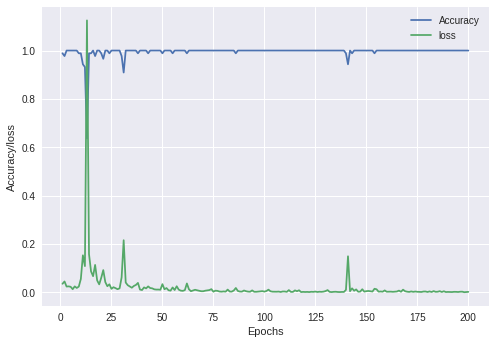

In [26]:
# 学習経過をプロット
import matplotlib.pyplot as plt 

plt.plot(range(1, 201), history.history['acc'], label="Accuracy")         # epocに応じて変更
plt.plot(range(1, 201), history.history['loss'], label="loss")         # epocに応じて変更
plt.xlabel('Epochs') 
plt.ylabel('Accuracy/loss') 
plt.legend() 
plt.show()

### 推論のテスト

予めGoogleドライブに保存してある画像で推論実施（事前マウント必要）。

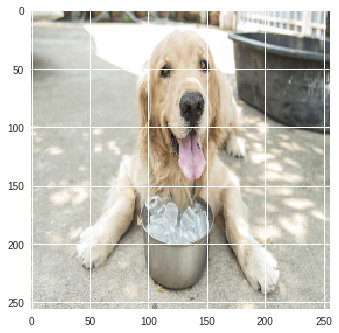

--------------------------------------
予測スコア: 100.0 %
予測ラベル: 2
[凡例] 0 : くるみ  ,  1 : モカ  ,  2 : その他のワンちゃん


In [33]:
#---認識テスト画像の確認表示----
import numpy as np
from PIL import Image
img_width = 256 ; img_height = 256
#file_path = './kuru1.jpg'  # 読み込むファイルを指定(local)
file_path = 'gdrive/My Drive/otr_dog3.jpg'  # 読み込むファイルを指定(google drive)
img = Image.open(file_path).convert('RGB') # Gray->L, RGB->RGB
img = img.resize((img_width, img_height))
x = np.array(img, dtype=np.float32)
x = x / 255
plt.imshow(x)
plt.show()

#---テスト画像の変換----
from keras.preprocessing.image import img_to_array, load_img
img = img_to_array(load_img(file_path, target_size=(32,32)))  # 読み込み
img_nad = img_to_array(img)/255   # 0-1に変換
img_nad = img_nad[None, ...]  #4次元配列に変換

#---読み込んだテスト画像で推論-----
model.load_weights('MyNet1.h5')
pred = model.predict(img_nad, batch_size=1, verbose=0)
pred_score = np.max(pred)
pred_label = np.argmax(pred)
print('--------------------------------------')
print('予測スコア:', pred_score * 100 , '%')       # 
print('予測ラベル:', pred_label)    # 
print('[凡例] 0 : くるみ  ,  1 : モカ  ,  2 : その他のワンちゃん')

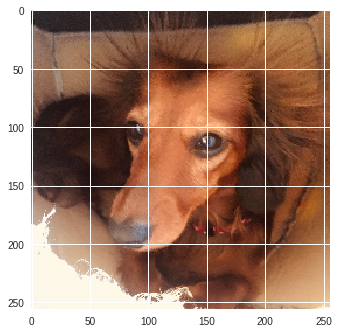

--------------------------------------
予測スコア: 72.33455777168274 %
予測ラベル: 0
[凡例] 0 : くるみ  ,  1 : モカ  ,  2 : その他のワンちゃん


In [28]:
#@title
#---認識テスト画像の確認表示----
import numpy as np
from PIL import Image
img_width = 256 ; img_height = 256
#file_path = './kuru1.jpg'  # 読み込むファイルを指定(local)
file_path = 'gdrive/My Drive/kuru1.jpg'  # 読み込むファイルを指定(google drive)
img = Image.open(file_path).convert('RGB') # Gray->L, RGB->RGB
img = img.resize((img_width, img_height))
x = np.array(img, dtype=np.float32)
x = x / 255
plt.imshow(x)
plt.show()

#---テスト画像の変換----
from keras.preprocessing.image import img_to_array, load_img
img = img_to_array(load_img(file_path, target_size=(32,32)))  # 読み込み
img_nad = img_to_array(img)/255   # 0-1に変換
img_nad = img_nad[None, ...]  #4次元配列に変換

#---読み込んだテスト画像で推論-----
model.load_weights('MyNet1.h5')
pred = model.predict(img_nad, batch_size=1, verbose=0)
pred_score = np.max(pred)
pred_label = np.argmax(pred)
print('--------------------------------------')
print('予測スコア:', pred_score * 100 , '%')       # 
print('予測ラベル:', pred_label)    # 
print('[凡例] 0 : くるみ  ,  1 : モカ  ,  2 : その他のワンちゃん')

### （その他）メモ書きなど

めも \\
[自前画像で学習させるときの参考URL(Qiita)](https://qiita.com/neet-AI/items/2b3d7f743e4d6c6d8e10)

---